In [1]:
# # Diagnóstico Médico de Radiografía de Tórax con Aprendizaje Profundo

# ## Introducción
#
# En esta tarea, exploraremos el diagnóstico por imágenes médicas mediante la creación de un clasificador de radiografías de tórax utilizando Keras y TensorFlow. Seguiremos los pasos necesarios para preprocesar los datos, construir el modelo, abordar el desequilibrio de clases, entrenarlo (conceptualmente) y evaluarlo.
#
# **Objetivos:**
# * Preprocesar y preparar un conjunto de datos de rayos X.
# * Prevenir la fuga de datos eliminando la superposición de pacientes.
# * Utilizar aprendizaje por transferencia con DenseNet121.
# * Implementar una función de pérdida ponderada para manejar el desequilibrio de clases.
# * Evaluar el rendimiento usando curvas ROC y AUC.
# * Visualizar la atención del modelo usando GradCAM.

# ## 1. Importar Paquetes y Funciones

# In[ ]:
# Importaciones estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from glob import glob # Para encontrar archivos de imagen si es necesario

# Importaciones de TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K # Para la función de pérdida personalizada

# Importaciones de Scikit-learn para evaluación
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split # Si se necesitara re-dividir

# Para GradCAM
import cv2 # OpenCV para manipulación de imágenes en GradCAM

# Configuraciones
sns.set_style("whitegrid")
# %matplotlib inline

C:\Users\ULTRA GAMING\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
## 2. Cargar los Conjuntos de Datos

# ### 2.1 Carga de datos
# Cargamos los archivos CSV que contienen las etiquetas y la información de las imágenes.

# In[ ]:
# Definir rutas
BASE_DATA_PATH = "../data/"
IMAGE_PATH = os.path.join(BASE_DATA_PATH, "images-small/") # Asegúrate que termine con '/'
train_csv_path = os.path.join(BASE_DATA_PATH, "train-small.csv")
valid_csv_path = os.path.join(BASE_DATA_PATH, "valid-small.csv")
test_csv_path = os.path.join(BASE_DATA_PATH, "test.csv")
#MODEL_PATH = "../models/" # Ruta a la carpeta de modelos
#WEIGHTS_FILENAME = "pretrained_model.h5" # Archivo con los pesos específicos
#weights_path = os.path.join(MODEL_PATH, WEIGHTS_FILENAME)

# Columnas importantes
IMAGE_COL = 'Image'
PATIENT_ID_COL = 'PatientId' # Nombre corregido
LABEL_COLS = [ # Las 14 patologías
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
    'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

# Función auxiliar para cargar y preprocesar DFs
def load_and_preprocess_df(csv_path, id_col, label_cols):
    try:
        df = pd.read_csv(csv_path)
        # Limpiar IDs y etiquetas
        if id_col in df.columns:
            df[id_col] = df[id_col].astype(str).str.strip()
        else:
            print(f"Advertencia: Columna '{id_col}' no encontrada en {os.path.basename(csv_path)}")
            return None # No se puede continuar sin ID de paciente

        actual_labels = []
        for col in label_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
                actual_labels.append(col)
            else:
                print(f"Advertencia: Columna de etiqueta '{col}' no encontrada en {os.path.basename(csv_path)}")

        # Crear ruta completa a la imagen
        if IMAGE_COL in df.columns:
             if not os.path.isdir(IMAGE_PATH):
                  print(f"Error Crítico: El directorio de imágenes '{IMAGE_PATH}' no existe.")
                  raise FileNotFoundError(f"Directorio no encontrado: {IMAGE_PATH}")
             df['FullPath'] = df[IMAGE_COL].apply(lambda x: os.path.join(IMAGE_PATH, x))
             # Verificar si algunas imágenes existen (opcional, pero útil)
             # sample_exists = df['FullPath'].head().apply(os.path.exists).all()
             # if not sample_exists:
             #      print(f"Advertencia: Algunas rutas de imagen iniciales en {os.path.basename(csv_path)} no existen.")
        else:
             print(f"Advertencia: Columna '{IMAGE_COL}' no encontrada en {os.path.basename(csv_path)}")
             df['FullPath'] = None

        print(f"Cargado {os.path.basename(csv_path)}: {df.shape}")
        return df, actual_labels # Devolver también las etiquetas encontradas

    except FileNotFoundError:
        print(f"Error: No se encontró el archivo CSV: {csv_path}")
        return None, []
    except Exception as e:
        print(f"Error al cargar o procesar {csv_path}: {e}")
        return None, []

# Cargar los dataframes
train_df, actual_labels = load_and_preprocess_df(train_csv_path, PATIENT_ID_COL, LABEL_COLS)
valid_df, _ = load_and_preprocess_df(valid_csv_path, PATIENT_ID_COL, LABEL_COLS)
test_df, _ = load_and_preprocess_df(test_csv_path, PATIENT_ID_COL, LABEL_COLS)

# Verificar que todos se cargaron y que tenemos etiquetas
if train_df is None or valid_df is None or test_df is None:
    raise ValueError("Fallo al cargar uno o más archivos CSV. Revisa los mensajes de error.")
if not actual_labels:
     raise ValueError("No se encontraron columnas de etiquetas válidas en el archivo de entrenamiento.")

print(f"\nColumnas de patologías que se usarán: {actual_labels}")

Cargado train-small.csv: (1000, 17)
Cargado valid-small.csv: (200, 17)
Cargado test.csv: (420, 17)

Columnas de patologías que se usarán: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [3]:
### 2.2 Prevención de Fugas de Datos
# Verificamos y eliminamos la superposición de pacientes entre los conjuntos.

# In[ ]:
# --- EJERCICIO 1: Verificar Fugas ---

print("\n--- Verificando Superposición de Pacientes ---")

# Extraer IDs únicos
train_patient_ids = set(train_df[PATIENT_ID_COL].unique())
valid_patient_ids = set(valid_df[PATIENT_ID_COL].unique())
test_patient_ids = set(test_df[PATIENT_ID_COL].unique())

print(f"Pacientes únicos en Entrenamiento: {len(train_patient_ids)}")
print(f"Pacientes únicos en Validación: {len(valid_patient_ids)}")
print(f"Pacientes únicos en Prueba: {len(test_patient_ids)}")

# Calcular intersecciones
overlap_train_valid = train_patient_ids.intersection(valid_patient_ids)
overlap_train_test = train_patient_ids.intersection(test_patient_ids)
overlap_valid_test = valid_patient_ids.intersection(test_patient_ids)

print(f"\nSuperposición Entrenamiento <-> Validación: {len(overlap_train_valid)} pacientes")
print(f"Superposición Entrenamiento <-> Prueba: {len(overlap_train_test)} pacientes")
print(f"Superposición Validación <-> Prueba: {len(overlap_valid_test)} pacientes")

# Eliminar superposición de validación y prueba
patients_to_remove_from_valid = list(overlap_train_valid.union(overlap_valid_test))
patients_to_remove_from_test = list(overlap_train_test.union(overlap_valid_test))

print(f"\nEliminando {len(patients_to_remove_from_valid)} pacientes de Validación...")
valid_df_cleaned = valid_df[~valid_df[PATIENT_ID_COL].isin(patients_to_remove_from_valid)].copy()
print(f"Tamaño Validación Limpio: {valid_df_cleaned.shape}")

print(f"Eliminando {len(patients_to_remove_from_test)} pacientes de Prueba...")
test_df_cleaned = test_df[~test_df[PATIENT_ID_COL].isin(patients_to_remove_from_test)].copy()
print(f"Tamaño Prueba Limpio: {test_df_cleaned.shape}")

# Verificar limpieza
valid_patient_ids_cleaned = set(valid_df_cleaned[PATIENT_ID_COL].unique())
test_patient_ids_cleaned = set(test_df_cleaned[PATIENT_ID_COL].unique())
print("\nVerificación post-limpieza:")
print(f"Superposición Entrenamiento <-> Validación Limpia: {len(train_patient_ids.intersection(valid_patient_ids_cleaned))}")
print(f"Superposición Entrenamiento <-> Prueba Limpia: {len(train_patient_ids.intersection(test_patient_ids_cleaned))}")
print(f"Superposición Validación Limpia <-> Prueba Limpia: {len(valid_patient_ids_cleaned.intersection(test_patient_ids_cleaned))}")

if valid_df_cleaned.empty or test_df_cleaned.empty:
     print("\n¡ADVERTENCIA CRÍTICA! Uno de los conjuntos de validación o prueba quedó vacío después de la limpieza.")
     print("Esto indica un problema severo con la división inicial de datos. Revisa la estrategia de división.")
     # Considera detener la ejecución aquí si es necesario.
elif len(valid_df_cleaned) < 20 or len(test_df_cleaned) < 20:
     print("\nAdvertencia: Los conjuntos de validación o prueba son muy pequeños después de la limpieza (< 20 registros). La evaluación puede no ser fiable.")


--- Verificando Superposición de Pacientes ---
Pacientes únicos en Entrenamiento: 928
Pacientes únicos en Validación: 199
Pacientes únicos en Prueba: 389

Superposición Entrenamiento <-> Validación: 197 pacientes
Superposición Entrenamiento <-> Prueba: 0 pacientes
Superposición Validación <-> Prueba: 0 pacientes

Eliminando 197 pacientes de Validación...
Tamaño Validación Limpio: (2, 17)
Eliminando 0 pacientes de Prueba...
Tamaño Prueba Limpio: (420, 17)

Verificación post-limpieza:
Superposición Entrenamiento <-> Validación Limpia: 0
Superposición Entrenamiento <-> Prueba Limpia: 0
Superposición Validación Limpia <-> Prueba Limpia: 0

Advertencia: Los conjuntos de validación o prueba son muy pequeños después de la limpieza (< 20 registros). La evaluación puede no ser fiable.


In [4]:
### 2.3 Preparación de Imágenes
# Configuramos los generadores de datos usando `ImageDataGenerator` para cargar, preprocesar y aumentar las imágenes. Usaremos los dataframes **limpios** para validación y prueba.

# In[ ]:
print("\n--- Preparando Generadores de Imágenes ---")

# Parámetros
IMG_HEIGHT = 224 # O el tamaño que requiera tu DenseNet si es diferente
IMG_WIDTH = 224
BATCH_SIZE = 32 # Ajusta según la memoria de tu GPU

# Generador de Entrenamiento (con aumento)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05, # Reducido un poco
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generador de Validación/Prueba (solo reescalado)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Crear generadores desde DataFrames (usando los limpios para valid/test)
try:
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=None, # Rutas absolutas en 'FullPath'
        x_col='FullPath',
        y_col=actual_labels, # Usar las etiquetas encontradas
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode='rgb', # DenseNet pre-entrenada espera 3 canales
        class_mode='raw', # Para multi-label
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    print("Generador de Entrenamiento creado.")

    # Asegurarse que valid_df_cleaned no esté vacío antes de crear el generador
    if not valid_df_cleaned.empty:
        validation_generator = val_test_datagen.flow_from_dataframe(
            dataframe=valid_df_cleaned,
            directory=None,
            x_col='FullPath',
            y_col=actual_labels,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            color_mode='rgb',
            class_mode='raw',
            batch_size=BATCH_SIZE,
            shuffle=False # No mezclar validación
        )
        print("Generador de Validación creado.")
    else:
        validation_generator = None
        print("Advertencia: El conjunto de validación está vacío, no se creó el generador.")

    # Asegurarse que test_df_cleaned no esté vacío
    if not test_df_cleaned.empty:
        test_generator = val_test_datagen.flow_from_dataframe(
            dataframe=test_df_cleaned,
            directory=None,
            x_col='FullPath',
            y_col=actual_labels, # Incluir etiquetas para evaluación posterior si es necesario
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            color_mode='rgb',
            class_mode='raw', # O 'None' si solo quieres las imágenes para predecir
            batch_size=BATCH_SIZE, # O 1 si predices una por una
            shuffle=False # No mezclar prueba
        )
        print("Generador de Prueba creado.")
    else:
        test_generator = None
        print("Advertencia: El conjunto de prueba está vacío, no se creó el generador.")

except Exception as e:
    print(f"\nError al crear los generadores: {e}")
    print("Verifica las rutas de las imágenes y los dataframes.")
    raise e



--- Preparando Generadores de Imágenes ---
Found 1000 validated image filenames.
Generador de Entrenamiento creado.
Found 2 validated image filenames.
Generador de Validación creado.
Found 420 validated image filenames.
Generador de Prueba creado.


In [5]:
## 3. Desarrollo del Modelo

# ### 3.1 Abordar el Desequilibrio de Clases
# Calculamos las frecuencias y los pesos para la función de pérdida ponderada.

# In[ ]:
# --- EJERCICIO 2: Calcular Frecuencias de Clases ---

def compute_class_freqs(labels_df, label_columns):
    """Calcula la frecuencia de casos positivos y negativos."""
    freqs = {}
    total_examples = len(labels_df)
    if total_examples == 0: return freqs
    for label in label_columns:
        pos_count = labels_df[label].sum()
        neg_count = total_examples - pos_count
        freqs[label] = (pos_count / total_examples, neg_count / total_examples)
    return freqs

print("\n--- Calculando Frecuencias de Clase (Entrenamiento) ---")
class_frequencies = compute_class_freqs(train_df, actual_labels)
print(class_frequencies) # Descomentar para ver


--- Calculando Frecuencias de Clase (Entrenamiento) ---
{'Atelectasis': (0.106, 0.894), 'Cardiomegaly': (0.02, 0.98), 'Consolidation': (0.033, 0.967), 'Edema': (0.016, 0.984), 'Effusion': (0.128, 0.872), 'Emphysema': (0.013, 0.987), 'Fibrosis': (0.014, 0.986), 'Hernia': (0.002, 0.998), 'Infiltration': (0.175, 0.825), 'Mass': (0.045, 0.955), 'Nodule': (0.054, 0.946), 'Pleural_Thickening': (0.021, 0.979), 'Pneumonia': (0.01, 0.99), 'Pneumothorax': (0.038, 0.962)}


In [6]:
# Calcular Pesos Positivos y Negativos
# w_pos = freq_neg
# w_neg = freq_pos
pos_weights = np.array([class_frequencies[label][1] for label in actual_labels])
neg_weights = np.array([class_frequencies[label][0] for label in actual_labels])

print("\nPesos calculados (ordenados según actual_labels):")
print(f"Pesos Positivos (w_pos): {pos_weights}")
print(f"Pesos Negativos (w_neg): {neg_weights}")



Pesos calculados (ordenados según actual_labels):
Pesos Positivos (w_pos): [0.894 0.98  0.967 0.984 0.872 0.987 0.986 0.998 0.825 0.955 0.946 0.979
 0.99  0.962]
Pesos Negativos (w_neg): [0.106 0.02  0.033 0.016 0.128 0.013 0.014 0.002 0.175 0.045 0.054 0.021
 0.01  0.038]


In [7]:
# --- EJERCICIO 3: Obtener Pérdida Ponderada ---

def get_weighted_loss(pos_weights_arr, neg_weights_arr, epsilon=1e-7):
    """
    Genera una función de pérdida de entropía cruzada binaria ponderada.

    Args:
      pos_weights_arr (np.array): Array de pesos para la clase positiva (1) para cada etiqueta.
      neg_weights_arr (np.array): Array de pesos para la clase negativa (0) para cada etiqueta.
      epsilon (float): Pequeño valor para evitar log(0).

    Returns:
      function: Función de pérdida personalizada para Keras.
    """
    def weighted_loss(y_true, y_pred):
        """
        Calcula la pérdida ponderada.

        Args:
          y_true (tf.Tensor): Etiquetas verdaderas (shape: [batch, n_classes]).
          y_pred (tf.Tensor): Predicciones del modelo (shape: [batch, n_classes]).

        Returns:
          tf.Tensor: Pérdida ponderada promedio para el lote.
        """
        # Convertir y_true a float si es necesario (Keras suele hacerlo)
        y_true = tf.cast(y_true, dtype=tf.float32)

        # Calcular la pérdida para cada clase y ejemplo
        # log(p + epsilon)
        log_y_pred = K.log(y_pred + epsilon)
        # log(1 - p + epsilon)
        log_1_y_pred = K.log(1.0 - y_pred + epsilon)

        # Multiplicar por pesos y etiquetas
        # w_pos * y * log(p)
        loss_pos = pos_weights_arr * y_true * log_y_pred
        # w_neg * (1-y) * log(1-p)
        loss_neg = neg_weights_arr * (1.0 - y_true) * log_1_y_pred

        # Sumar las pérdidas positiva y negativa
        loss = - (loss_pos + loss_neg) # El negativo es de la fórmula BCE

        # Promediar sobre todas las clases y luego sobre el lote
        # O sumar sobre las clases y promediar sobre el lote
        # Promedio sobre clases:
        loss_per_example = K.mean(loss, axis=1)
        # Promedio sobre el lote:
        batch_loss = K.mean(loss_per_example)

        # Alternativa: Promedio sobre todo (clases y lote)
        # batch_loss = K.mean(loss)

        return batch_loss

    return weighted_loss

# Crear la instancia de la función de pérdida
weighted_loss_func = get_weighted_loss(pos_weights, neg_weights)
print("\nFunción de pérdida ponderada creada.")


Función de pérdida ponderada creada.


In [15]:
MODEL_PATH = "../models" # Ruta a la carpeta de modelos
BASE_MODEL_WEIGHTS_FILENAME = "densenet.hdf5" # Pesos para la base DenseNet
FINE_TUNED_WEIGHTS_FILENAME = "pretrained_model.h5" # Pesos para el modelo completo afinado

base_model_weights_path = os.path.join(MODEL_PATH, BASE_MODEL_WEIGHTS_FILENAME)
fine_tuned_weights_path = os.path.join(MODEL_PATH, FINE_TUNED_WEIGHTS_FILENAME)

In [16]:
### 3.2 DenseNet121 con Múltiples Fases de Carga de Pesos

# Cargamos la arquitectura DenseNet121, luego los pesos base de `densenet.hdf5`, añadimos nuestra cabecera, y finalmente cargamos los pesos afinados de `pretrained_model.h5`.

# In[ ]:
print("\n--- Construyendo Modelo DenseNet121 y Cargando Pesos en Fases ---")

# 1. Cargar arquitectura base SIN pesos iniciales de Keras
try:
    base_model = DenseNet121(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    print("Arquitectura base DenseNet121 creada (sin pesos iniciales de Keras).")
except Exception as e:
    print(f"Error al crear la arquitectura base DenseNet121: {e}")
    raise e

# 2. Cargar pesos base desde densenet.hdf5 en la base_model
print(f"\nCargando pesos base desde: {base_model_weights_path}")
try:
    # Es crucial que los pesos en densenet.hdf5 sean solo para la parte base (include_top=False)
    base_model.load_weights(base_model_weights_path)
    print("Pesos base cargados exitosamente en `base_model` desde densenet.hdf5.")
except FileNotFoundError:
    print(f"ADVERTENCIA: No se encontró el archivo de pesos base '{BASE_MODEL_WEIGHTS_FILENAME}' en '{MODEL_PATH}'.")
    print("La base_model usará pesos inicializados aleatoriamente si este archivo falta.")
except Exception as e:
    print(f"Error al cargar los pesos base desde {base_model_weights_path}: {e}")
    print("Verifica que los pesos en densenet.hdf5 sean compatibles con la arquitectura DenseNet121 (include_top=False).")
    # Podrías decidir detenerte aquí si estos pesos son cruciales: # raise e

# 3. Añadir cabecera personalizada
x = base_model.output
x = GlobalAveragePooling2D(name='global_avg_pool')(x)
num_classes = len(actual_labels)
predictions = Dense(num_classes, activation='sigmoid', name='predictions')(x)

# 4. Crear el modelo final combinado
model = Model(inputs=base_model.input, outputs=predictions, name='DenseNet121_XRay_Custom_Pretrained')
print("\nModelo final (base + cabecera) creado.")

# 5. Cargar los pesos afinados (fine-tuned) para el modelo completo desde pretrained_model.h5
print(f"\nCargando pesos afinados para el modelo completo desde: {fine_tuned_weights_path}")
try:
    model.load_weights(fine_tuned_weights_path)
    print("Pesos afinados cargados exitosamente en el modelo completo desde pretrained_model.h5.")
except FileNotFoundError:
    print(f"ADVERTENCIA: No se encontró el archivo de pesos afinados '{FINE_TUNED_WEIGHTS_FILENAME}' en '{MODEL_PATH}'.")
    print("El modelo usará los pesos cargados en la base_model (de densenet.hdf5 o aleatorios) y la cabecera inicializada aleatoriamente.")
    # Considera detener si estos pesos son cruciales: # raise e
except Exception as e:
    print(f"Error al cargar los pesos afinados desde {fine_tuned_weights_path}: {e}")
    print("Verifica que los pesos en pretrained_model.h5 sean compatibles con la arquitectura completa del modelo (base+cabecera).")
    # Considera detener si estos pesos son cruciales: # raise e

# 6. Compilar el modelo (necesario para evaluar/predecir)
print("\nCompilando el modelo final...")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # LR baja es común para modelos ya entrenados
              loss=weighted_loss_func,
              metrics=[tf.keras.metrics.AUC(multi_label=True, name='auc'),
                       tf.keras.metrics.BinaryAccuracy(name='binary_acc')])

print("Modelo compilado exitosamente.")
model.summary()


--- Construyendo Modelo DenseNet121 y Cargando Pesos en Fases ---
Arquitectura base DenseNet121 creada (sin pesos iniciales de Keras).

Cargando pesos base desde: ../models\densenet.hdf5
Pesos base cargados exitosamente en `base_model` desde densenet.hdf5.

Modelo final (base + cabecera) creado.

Cargando pesos afinados para el modelo completo desde: ../models\pretrained_model.h5
Pesos afinados cargados exitosamente en el modelo completo desde pretrained_model.h5.

Compilando el modelo final...
Modelo compilado exitosamente.
Model: "DenseNet121_XRay_Custom_Pretrained"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                            

In [17]:
## 4. Entrenamiento (Opcional)
#
# Dado que hemos cargado pesos pre-entrenados específicos para esta tarea desde `pretrained_model.h5`, el re-entrenamiento completo podría no ser necesario, o solo se requeriría un *fine-tuning* con una tasa de aprendizaje muy baja.
#
# La celda de entrenamiento conceptual se mantiene igual, pero su utilidad depende de si los pesos cargados ya son óptimos o si se desea ajustarlos más.

# In[ ]:
# --- Entrenamiento (Ejemplo Conceptual / Fine-tuning) ---
print("\n--- Entrenamiento (Conceptual / Fine-tuning) ---")

EPOCHS = 1 # Ejemplo: Solo 1 época de fine-tuning con LR baja

# Solo entrenar si los generadores existen y no están vacíos
if train_generator and validation_generator:
    print(f"Iniciando fine-tuning de ejemplo por {EPOCHS} épocas...")
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)

    if steps_per_epoch == 0 or validation_steps == 0:
        print("Error: steps_per_epoch o validation_steps es cero. Verifica los generadores.")
    else:
        # Asegúrate de que el modelo esté compilado con un optimizador adecuado y LR baja
        # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), ...) # Re-compilar con LR baja si es necesario

        # Descomenta la siguiente línea para ejecutar el fine-tuning
        # history = model.fit(
        #     train_generator,
        #     steps_per_epoch=steps_per_epoch,
        #     epochs=EPOCHS,
        #     validation_data=validation_generator,
        #     validation_steps=validation_steps
        # )
        print("El código de 'model.fit()' está comentado para evitar ejecución larga.")
        print("Descomenta la sección 'history = model.fit(...)' para entrenar/fine-tuning.")
        history = None
else:
    print("Entrenamiento/Fine-tuning omitido porque el generador de entrenamiento o validación no está disponible o está vacío.")
    history = None


# ### 4.1 Entrenamiento con el conjunto de datos más grande
# (Sección informativa, sin cambios)

# ## 5. Predicción y Evaluación
#
# Evaluamos el modelo (con los pesos cargados de `pretrained_model.h5`) en el conjunto de prueba **limpio**.



--- Entrenamiento (Conceptual / Fine-tuning) ---
Iniciando fine-tuning de ejemplo por 1 épocas...
El código de 'model.fit()' está comentado para evitar ejecución larga.
Descomenta la sección 'history = model.fit(...)' para entrenar/fine-tuning.


In [18]:
print("\n--- Predicción y Evaluación (Conjunto de Prueba Limpio) ---")

# No necesitamos cargar modelo aquí, ya lo tenemos en 'model' con los pesos cargados

# Realizar predicciones en el conjunto de prueba
if test_generator:
    print("Realizando predicciones en el conjunto de prueba...")
    test_generator.reset()
    try:
        # Intentar acceder a las etiquetas directamente
        y_true = test_generator.labels
        if y_true is None: # Si class_mode era 'None' o no se pudieron obtener
             raise AttributeError("Labels not directly available from generator.")
    except AttributeError:
         # Obtener etiquetas iterando (si es necesario)
         print("Obteniendo etiquetas verdaderas iterando sobre test_generator...")
         y_true_list = []
         num_batches = len(test_generator)
         for i in range(num_batches):
             _, labels_batch = test_generator[i]
             y_true_list.append(labels_batch)
             # if i % 10 == 0: print(f" Obteniendo etiquetas lote {i+1}/{num_batches}") # Progreso opcional
         y_true = np.vstack(y_true_list)
         print("Etiquetas verdaderas obtenidas.")


    # Obtener predicciones
    test_generator.reset() # Reiniciar antes de predecir
    y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1)
    print("Predicciones completadas.")
    print(f"Forma de y_true: {y_true.shape}")
    print(f"Forma de y_pred_probs: {y_pred_probs.shape}")

    # Asegurarse que las formas coincidan
    if y_true.shape[0] != y_pred_probs.shape[0]: # Comparar solo la dimensión del lote
         print(f"¡Advertencia de forma! y_true: {y_true.shape[0]} muestras, y_pred_probs: {y_pred_probs.shape[0]} muestras.")
         min_len = min(len(y_true), len(y_pred_probs))
         y_true = y_true[:min_len]
         y_pred_probs = y_pred_probs[:min_len]
         print(f"Formas ajustadas a longitud {min_len}.")
    elif y_true.shape[1] != y_pred_probs.shape[1]:
         print(f"¡Error de forma! Número de clases no coincide. y_true: {y_true.shape[1]}, y_pred_probs: {y_pred_probs.shape[1]}")
         y_true = None # Invalidar para evitar errores posteriores
         y_pred_probs = None

else:
    print("Evaluación omitida: Generador de prueba no disponible o vacío.")
    y_true = None
    y_pred_probs = None



--- Predicción y Evaluación (Conjunto de Prueba Limpio) ---
Realizando predicciones en el conjunto de prueba...
14/14 [==============================] - 28s 2s/step
Predicciones completadas.
Forma de y_true: (420, 14)
Forma de y_pred_probs: (420, 14)



--- Calculando y Graficando Curvas ROC y AUC ---


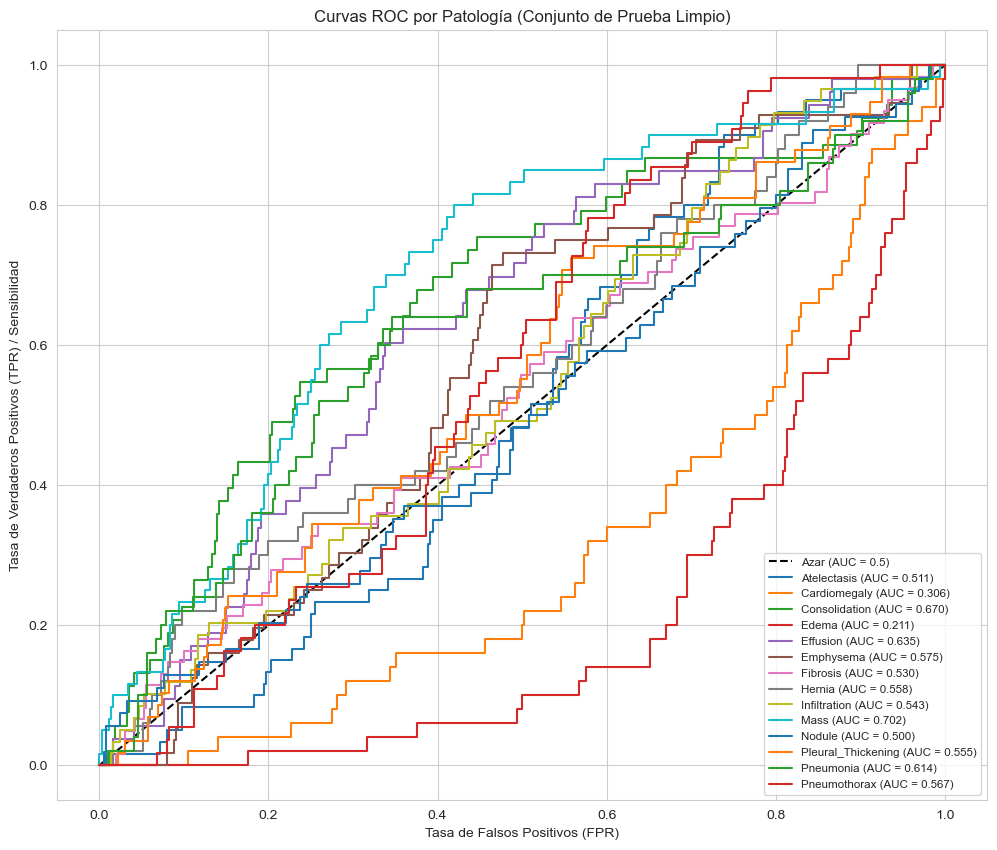


AUC Promedio (Macro) sobre todas las patologías: 0.5340

AUC por Patología:
- Mass                : 0.7016
- Consolidation       : 0.6700
- Effusion            : 0.6347
- Pneumonia           : 0.6145
- Emphysema           : 0.5748
- Pneumothorax        : 0.5674
- Hernia              : 0.5583
- Pleural_Thickening  : 0.5551
- Infiltration        : 0.5427
- Fibrosis            : 0.5298
- Atelectasis         : 0.5106
- Nodule              : 0.4996
- Cardiomegaly        : 0.3064
- Edema               : 0.2111


In [20]:
### 5.1 Curva ROC y AUROC
# Calculamos y visualizamos la curva ROC y el área bajo la curva (AUC) para cada patología.

# In[ ]:
# Calcular y graficar ROC/AUC si tenemos predicciones
if y_true is not None and y_pred_probs is not None:
    print("\n--- Calculando y Graficando Curvas ROC y AUC ---")
    plt.figure(figsize=(12, 10))
    plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)') # Línea de referencia

    auc_scores = {}

    for i, label in enumerate(actual_labels):
        try:
            # Asegurarse que haya positivos y negativos para calcular ROC
            if len(np.unique(y_true[:, i])) > 1:
                fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred_probs[:, i])
                auc_val = auc(fpr, tpr)
                auc_scores[label] = auc_val
                plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_val:.3f})')
            else:
                print(f"Advertencia: No se puede calcular ROC/AUC para '{label}' (solo una clase presente en y_true).")
                auc_scores[label] = np.nan # Marcar como no calculable
        except Exception as e:
            print(f"Error al calcular ROC/AUC para '{label}': {e}")
            auc_scores[label] = np.nan

    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Sensibilidad')
    plt.title('Curvas ROC por Patología (Conjunto de Prueba Limpio)')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.show()

    # Mostrar AUC promedio (macro)
    mean_auc = np.nanmean(list(auc_scores.values())) # Promedio ignorando NaNs
    print(f"\nAUC Promedio (Macro) sobre todas las patologías: {mean_auc:.4f}")

    # Mostrar AUCs individuales
    print("\nAUC por Patología:")
    # Ordenar por AUC descendente
    sorted_auc = sorted(auc_scores.items(), key=lambda item: item[1] if not np.isnan(item[1]) else -1, reverse=True)
    for label, score in sorted_auc:
         if not np.isnan(score):
              print(f"- {label:<20}: {score:.4f}")
         else:
              print(f"- {label:<20}: No Calculado")

else:
    print("No se pueden calcular métricas ROC/AUC porque faltan y_true o y_pred_probs.")



In [13]:
from PIL import Image


--- Visualización GradCAM ---
Usando 'conv5_block16_2_conv' como última capa convolucional para GradCAM.

Procesando GradCAM para: 00014018_006.png
1/1 [==============================] - 3s 3s/step
  Predicción principal: Hernia (Prob: 0.613)
  Etiquetas verdaderas: ['Atelectasis', 'Consolidation', 'Effusion', 'Emphysema', 'Infiltration', 'Mass']


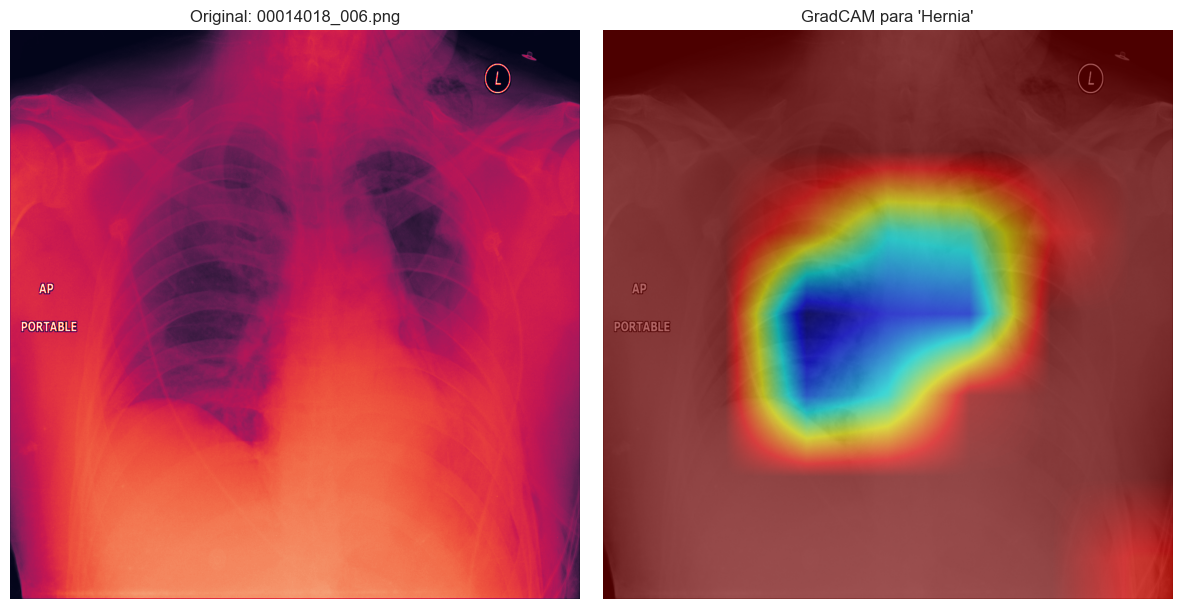


Procesando GradCAM para: 00019470_001.png
1/1 [==============================] - 0s 86ms/step
  Predicción principal: Hernia (Prob: 0.925)
  Etiquetas verdaderas: ['Atelectasis', 'Hernia']


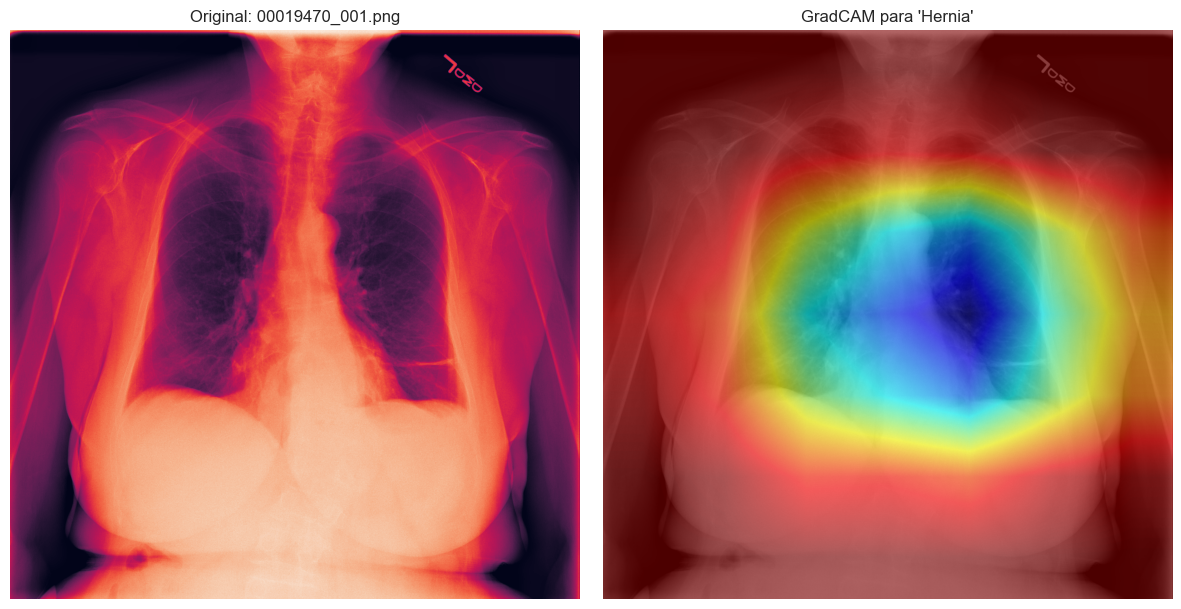


Procesando GradCAM para: 00022622_009.png
1/1 [==============================] - 0s 237ms/step
  Predicción principal: Hernia (Prob: 0.807)
  Etiquetas verdaderas: ['Nodule']


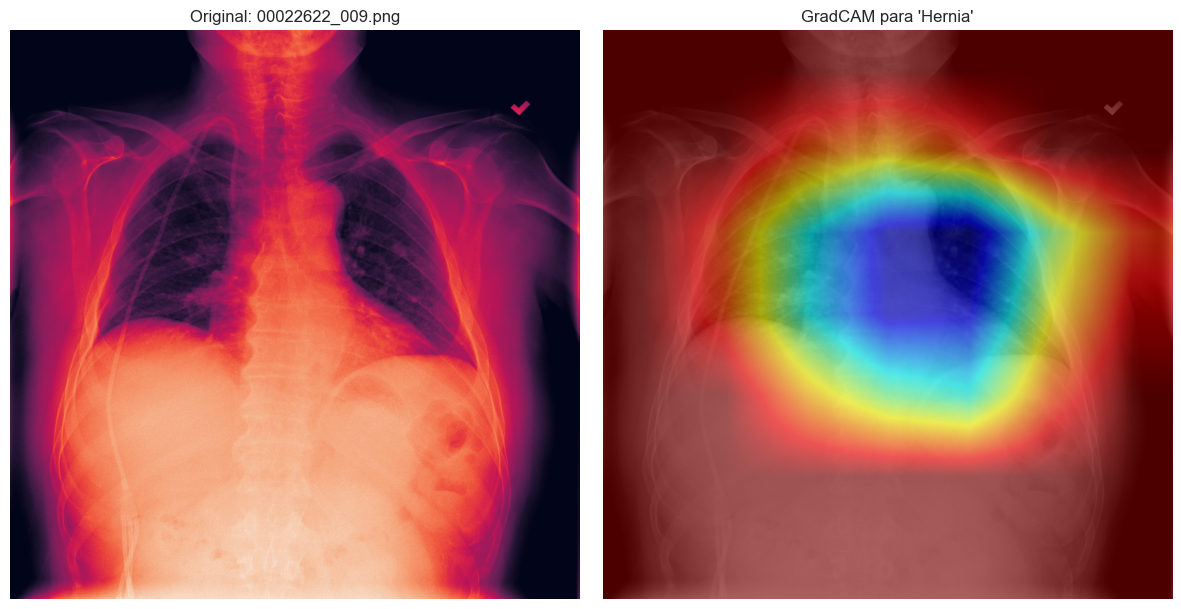

In [21]:
### 5.2 Visualizar el Aprendizaje con GradCAM
# GradCAM ayuda a visualizar qué regiones de la imagen de entrada fueron más importantes para que el modelo tomara una decisión específica.

# In[ ]:
# --- Implementación de GradCAM ---
# (Código de funciones get_img_array, make_gradcam_heatmap, display_gradcam sin cambios)
def get_img_array(img_path, size):
    """Carga y preprocesa una imagen para el modelo."""
    try:
        img = keras.utils.load_img(img_path, target_size=size, color_mode='rgb') # Cargar como RGB
        array = keras.utils.img_to_array(img)
        array = array / 255.0 # Normalizar a [0,1]
        array = np.expand_dims(array, axis=0) # Añadir dimensión de batch
        return array
    except Exception as e:
        print(f"Error al cargar imagen {img_path}: {e}")
        return None

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Genera el heatmap de GradCAM."""
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + K.epsilon()) # Añadido epsilon
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.6):
    """Muestra el heatmap superpuesto en la imagen original."""
    try:
        img = keras.utils.load_img(img_path)
        img = keras.utils.img_to_array(img)
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = jet * alpha + img * (1 - alpha)
        superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
        return superimposed_img
    except Exception as e:
        print(f"Error al generar imagen GradCAM para {img_path}: {e}")
        return None

# --- Visualización GradCAM ---
print("\n--- Visualización GradCAM ---")
last_conv_layer_name = None
for layer in reversed(model.layers):
     if isinstance(layer, keras.layers.Conv2D):
          last_conv_layer_name = layer.name
          break

if last_conv_layer_name:
    print(f"Usando '{last_conv_layer_name}' como última capa convolucional para GradCAM.")
    if test_df_cleaned is not None and not test_df_cleaned.empty:
        num_gradcam_imgs = 3
        sample_indices = random.sample(range(len(test_df_cleaned)), min(num_gradcam_imgs, len(test_df_cleaned)))
        for i, idx in enumerate(sample_indices):
            row = test_df_cleaned.iloc[idx]
            img_path = row['FullPath']
            img_filename = row[IMAGE_COL]
            print(f"\nProcesando GradCAM para: {img_filename}")
            if not os.path.exists(img_path):
                 print(f"  Imagen no encontrada: {img_path}"); continue
            img_array = get_img_array(img_path, size=(IMG_HEIGHT, IMG_WIDTH))
            if img_array is None: continue
            preds = model.predict(img_array)[0]
            predicted_class_idx = np.argmax(preds)
            predicted_class_label = actual_labels[predicted_class_idx]
            predicted_prob = preds[predicted_class_idx]
            print(f"  Predicción principal: {predicted_class_label} (Prob: {predicted_prob:.3f})")
            true_labels_list = [l for l, val in row[actual_labels].items() if val == 1]
            print(f"  Etiquetas verdaderas: {true_labels_list if true_labels_list else 'Ninguna'}")
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=predicted_class_idx)
            superimposed_image = display_gradcam(img_path, heatmap)
            if superimposed_image is not None:
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1); plt.imshow(Image.open(img_path)); plt.title(f"Original: {img_filename}"); plt.axis('off')
                plt.subplot(1, 2, 2); plt.imshow(superimposed_image); plt.title(f"GradCAM para '{predicted_class_label}'"); plt.axis('off')
                plt.tight_layout(); plt.show()
            else: print("  No se pudo generar la imagen GradCAM superpuesta.")
    else: print("No se pueden generar ejemplos GradCAM porque el conjunto de prueba limpio está vacío o no disponible.")
else: print("No se encontró una capa convolucional adecuada para GradCAM.")




--- Visualización GradCAM Específica para Predicciones de 'Mass' ---
Buscando imágenes predichas como 'Mass' en el conjunto de prueba limpio...

Procesando GradCAM para: 00005094_016.png (Predicho como 'Mass')
  Probabilidad de 'Mass': 0.486
  Etiquetas verdaderas: ['Edema', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening']


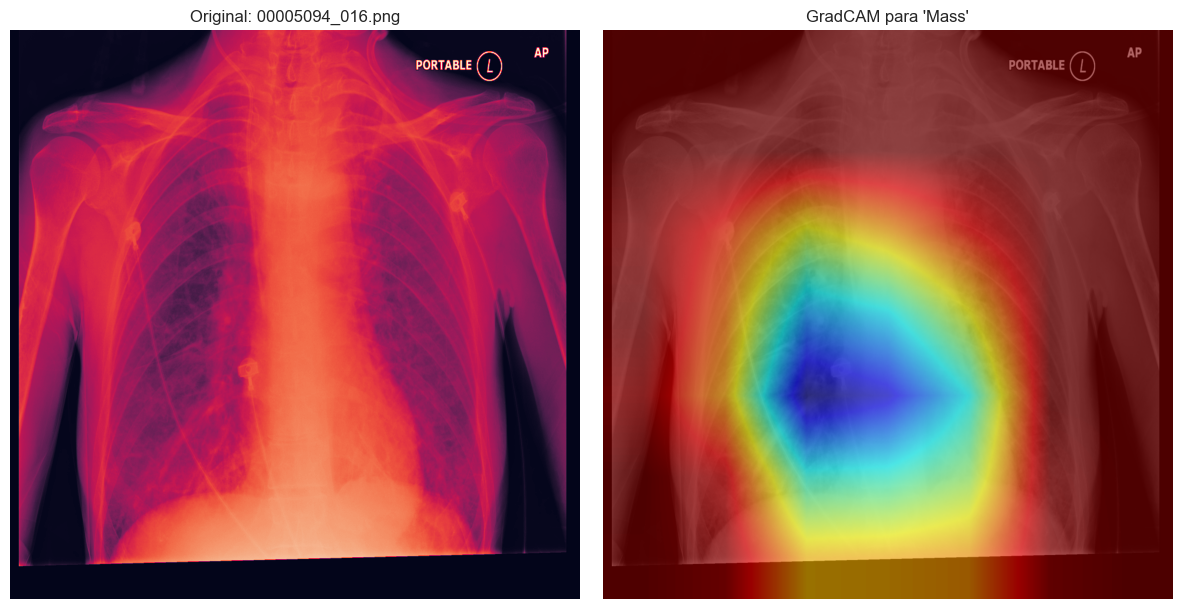


Procesando GradCAM para: 00001170_045.png (Predicho como 'Mass')
  Probabilidad de 'Mass': 0.818
  Etiquetas verdaderas: ['Pleural_Thickening', 'Pneumothorax']


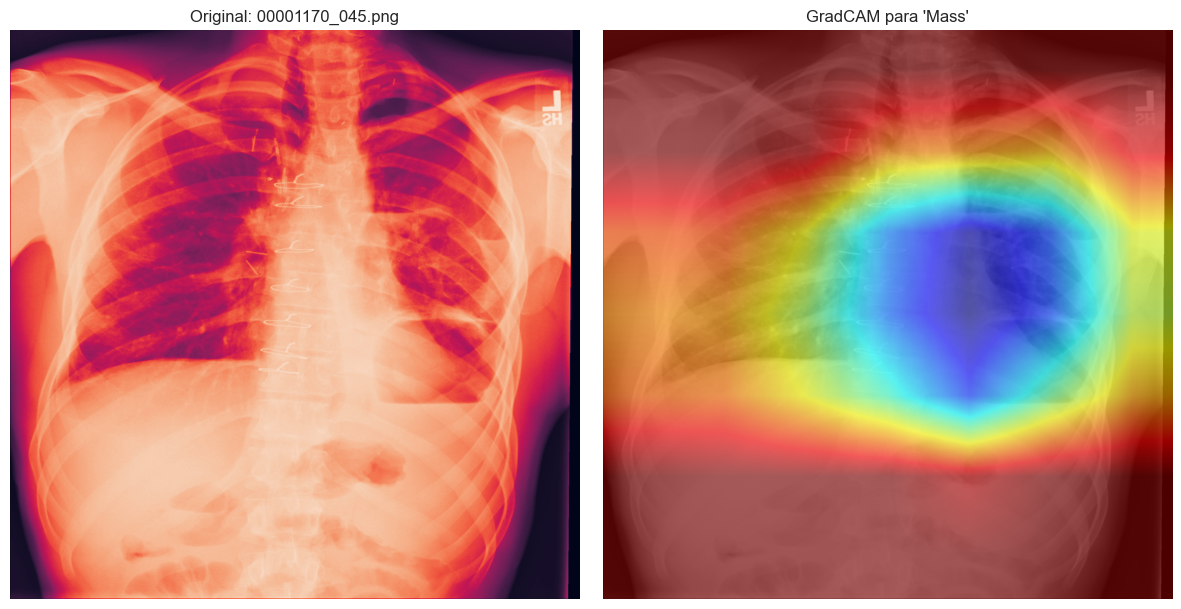


Procesando GradCAM para: 00004747_000.png (Predicho como 'Mass')
  Probabilidad de 'Mass': 0.758
  Etiquetas verdaderas: ['Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Pleural_Thickening']


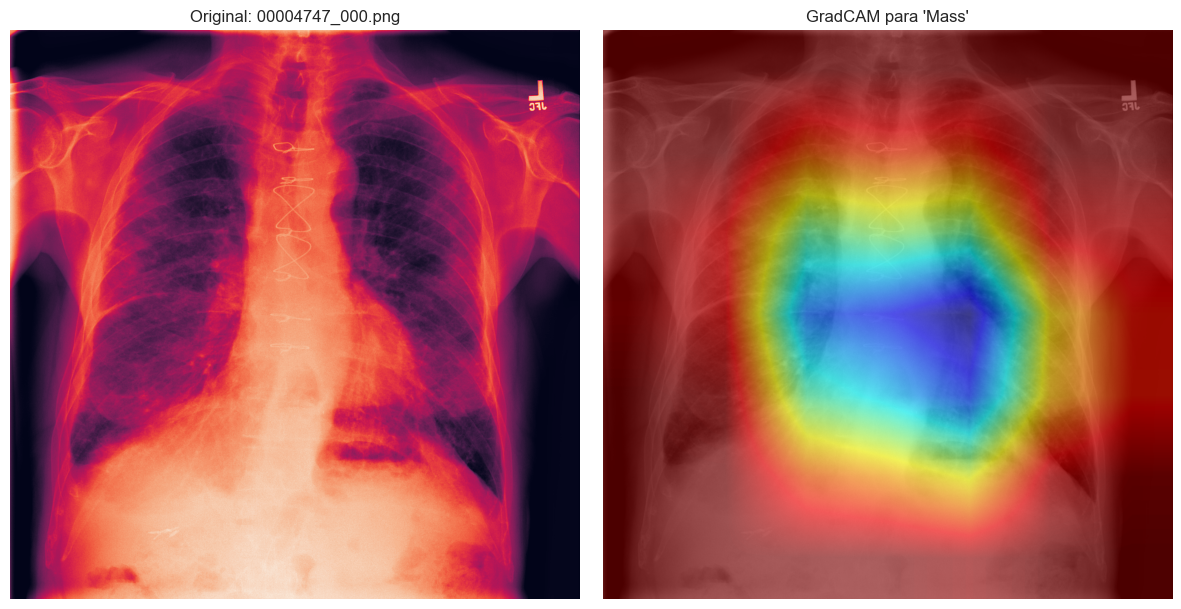

In [22]:
print("\n--- Visualización GradCAM Específica para Predicciones de 'Mass' ---")

if last_conv_layer_name and (test_df_cleaned is not None and not test_df_cleaned.empty):
    print(f"Buscando imágenes predichas como 'Mass' en el conjunto de prueba limpio...")
    
    # Asegurarse que 'Mass' está en nuestras etiquetas
    if 'Mass' not in actual_labels:
        print("La etiqueta 'Mass' no está en la lista de 'actual_labels'. No se puede continuar.")
    else:
        mass_label_index = actual_labels.index('Mass') # Obtener el índice de la etiqueta 'Mass'
        
        count_mass_predictions_shown = 0
        max_mass_gradcam_imgs = 3 # Cuántas mostrar

        # Iterar sobre el conjunto de prueba limpio
        # Para no procesar todo el dataset si es grande, podemos tomar una muestra o iterar hasta encontrar suficientes
        # Aquí iteraremos sobre una muestra aleatoria para eficiencia
        
        # Crear una copia para barajar sin afectar el original si se usa en otras celdas
        shuffled_test_df = test_df_cleaned.sample(frac=1, random_state=42).reset_index(drop=True)

        for idx, row in shuffled_test_df.iterrows():
            if count_mass_predictions_shown >= max_mass_gradcam_imgs:
                break # Salir si ya mostramos suficientes

            img_path = row['FullPath']
            img_filename = row[IMAGE_COL]

            if not os.path.exists(img_path):
                # print(f"  Imagen no encontrada: {img_path}") # Puede ser verboso
                continue

            img_array = get_img_array(img_path, size=(IMG_HEIGHT, IMG_WIDTH))
            if img_array is None:
                continue

            # Obtener predicciones para esta imagen
            preds_for_img = model.predict(img_array, verbose=0)[0] # verbose=0 para menos output
            
            # Verificar si la predicción principal es 'Mass'
            # La predicción principal es la clase con la probabilidad más alta
            # Pero también queremos que la probabilidad de 'Mass' sea alta
            
            predicted_class_idx_overall = np.argmax(preds_for_img) # Índice de la clase con mayor prob. general
            predicted_class_label_overall = actual_labels[predicted_class_idx_overall]
            
            prob_mass = preds_for_img[mass_label_index] # Probabilidad específica de 'Mass'

            # Condición: ¿Es 'Mass' la clase con mayor probabilidad?
            # Opcional: ¿Y la probabilidad de 'Mass' supera un umbral? (ej. > 0.5)
            if predicted_class_label_overall == 'Mass': # and prob_mass > 0.5 (umbral opcional)
                print(f"\nProcesando GradCAM para: {img_filename} (Predicho como 'Mass')")
                print(f"  Probabilidad de 'Mass': {prob_mass:.3f}")
                true_labels_list = [l for l, val in row[actual_labels].items() if val == 1]
                print(f"  Etiquetas verdaderas: {true_labels_list if true_labels_list else 'Ninguna'}")

                # Generar heatmap para la clase 'Mass'
                heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=mass_label_index)
                superimposed_image = display_gradcam(img_path, heatmap)

                if superimposed_image is not None:
                    plt.figure(figsize=(12, 6))
                    plt.subplot(1, 2, 1)
                    plt.imshow(Image.open(img_path))
                    plt.title(f"Original: {img_filename}")
                    plt.axis('off')

                    plt.subplot(1, 2, 2)
                    plt.imshow(superimposed_image)
                    plt.title(f"GradCAM para 'Mass'")
                    plt.axis('off')
                    plt.tight_layout()
                    plt.show()
                    count_mass_predictions_shown += 1
                else:
                    print(f"  No se pudo generar la imagen GradCAM superpuesta para {img_filename}.")
        
        if count_mass_predictions_shown == 0:
            print("\nNo se encontraron imágenes en la muestra del conjunto de prueba donde 'Mass' fuera la predicción principal (o no se pudieron generar GradCAMs).")
            print("Puedes probar con una muestra más grande o ajustar los criterios.")

else:
    print("No se puede generar GradCAM para 'Mass': no se encontró la última capa convolucional o el conjunto de prueba está vacío.")


In [23]:
import io

import base64 # Para codificar imágenes para el LLM (simulado)

# (Simulación) Para OpenAI API
from openai import OpenAI
client = OpenAI(api_key="sk-Pa28ta3mfTOfAnhXCDDoAlzxnH5_LE-pCwSlPDccL5T3BlbkFJj2Qwr83HP_DJ4QOspfOdSuKpp5HpNO5VtH3LwVma4A")

In [24]:
def display_gradcam_pil(original_pil_image, heatmap_np, alpha=0.6):
    img_for_cv = np.array(original_pil_image.convert('RGB'))
    heatmap_resized = cv2.resize(heatmap_np, (img_for_cv.shape[1], img_for_cv.shape[0])); heatmap_uint8 = np.uint8(255 * heatmap_resized)
    jet_heatmap = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET); jet_heatmap_rgb = cv2.cvtColor(jet_heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img_np = jet_heatmap_rgb * alpha + img_for_cv * (1 - alpha); superimposed_img_np = np.clip(superimposed_img_np, 0, 255).astype(np.uint8)
    return Image.fromarray(superimposed_img_np)


--- Generando Reporte Radiológico Simulado para una Imagen de Prueba ---
Imagen seleccionada para reporte: 00019406_001.png (Path: ../data/images-small/00019406_001.png)
  Predicción CNN: Pneumothorax (Prob: 0.235)


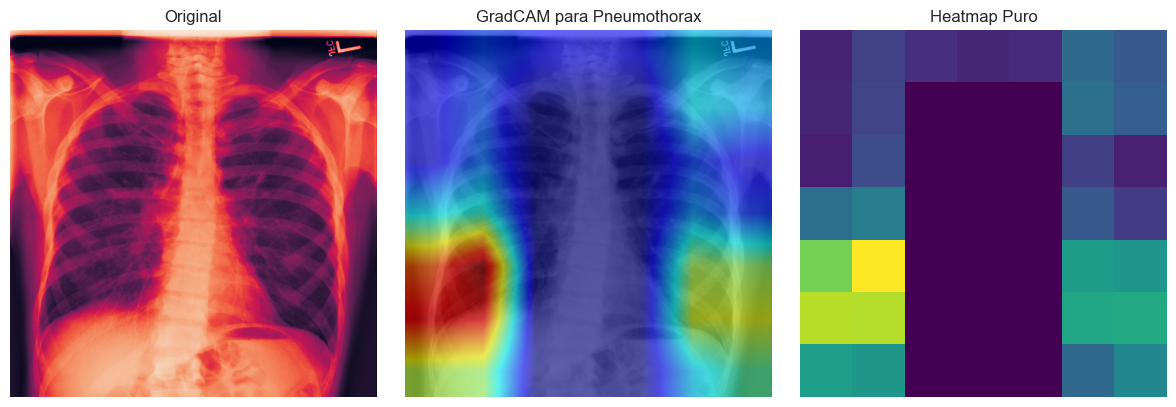


--- Llamada Simulada a API LLM ---
Prompt Enviado (resumen):

Eres un radiólogo experto con especialización en patologías pulmonares y análisis de radiografías de tórax.
Tu tarea es generar un reporte radiológico conciso y profesional basado en la información proporcionada.

**Información del Caso:**
- **Predicción Principal de IA:** Pneumothorax
- **Probabil...

Reporte Simulado Generado.

--- Reporte Radiológico Generado (Simulación) ---

**INFORME RADIOLÓGICO (SIMULADO)**

**Paciente:** No especificado
**Fecha del Examen:** 2025-05-15 16:09:54
**Tipo de Examen:** Radiografía de Tórax (AP/PA)

**Hallazgos de IA:**
La red neuronal convolucional ha identificado **Pneumothorax** como la patología principal con una probabilidad asociada del **23.48%**.
El mapa de activación de clase (GradCAM) sugiere que las regiones de interés para esta predicción se localizan en [describir brevemente dónde se activa el GradCAM, ej: el lóbulo superior derecho / región perihiliar].

**Interpretación Rad

In [32]:
def simulate_openai_call(prompt, original_image_b64, gradcam_image_b64, predicted_pathology, probability):
    """
    Simula una llamada a la API de OpenAI GPT (modelo con capacidad de visión).
    En una implementación real, esta función haría una petición HTTP a la API.
    """
    print("\n--- Llamada Simulada a API LLM ---")
    print("Prompt Enviado (resumen):")
    print(prompt[:300] + "...") # Mostrar solo una parte del prompt
    # print(f"Imagen Original (b64): {original_image_b64[:50]}...") # No imprimir toda la imagen
    # print(f"Imagen GradCAM (b64): {gradcam_image_b64[:50]}...")

    # Respuesta simulada del LLM
    mock_report = f"""
**INFORME RADIOLÓGICO (SIMULADO)**

**Paciente:** No especificado
**Fecha del Examen:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
**Tipo de Examen:** Radiografía de Tórax (AP/PA)

**Hallazgos de IA:**
La red neuronal convolucional ha identificado **{predicted_pathology}** como la patología principal con una probabilidad asociada del **{probability:.2%}**.
El mapa de activación de clase (GradCAM) sugiere que las regiones de interés para esta predicción se localizan en [describir brevemente dónde se activa el GradCAM, ej: el lóbulo superior derecho / región perihiliar].

**Interpretación Radiológica (Simulada por LLM):**

Observando la radiografía de tórax proporcionada y el mapa de calor GradCAM, se procede a la evaluación:

1.  **Calidad de la Imagen:** [Comentario simulado sobre la calidad, ej: La radiografía presenta una adecuada penetración e inspiración.]
2.  **Análisis de la Predicción de IA ({predicted_pathology}):**
    * Si la predicción parece plausible: "La predicción de {predicted_pathology} es consistente con [hallazgos visuales simulados en la imagen original que podrían corresponder, ej: una opacidad consolidativa en el área señalada por GradCAM]. Se recomienda correlacionar con la clínica del paciente."
    * Si la predicción parece dudosa: "Si bien la IA sugiere {predicted_pathology}, la visualización directa de la imagen en la región destacada por GradCAM no muestra signos inequívocos de [patología]. Podría tratarse de [diagnóstico diferencial simulado, ej: superposición de estructuras vasculares o un artefacto]. Se sugiere cautela y considerar [estudios adicionales simulados, ej: una TC de tórax o comparación con estudios previos] si la sospecha clínica es alta."
    * Si GradCAM es difuso o no apunta a nada claro: "El mapa de activación GradCAM es difuso / no concluyente, lo que dificulta la correlación directa de la predicción de {predicted_pathology} con un hallazgo focal específico."

3.  **Otros Hallazgos Relevantes (Simulado):** [Comentario simulado sobre otras estructuras visibles, ej: No se observan derrames pleurales significativos. Silueta cardíaca dentro de límites normales (o no, si se predijo Cardiomegalia, etc.). Campos pulmonares restantes sin alteraciones focales evidentes.]

**Conclusión (Simulada por LLM):**
Basado en el análisis asistido por IA, la principal consideración es **{predicted_pathology}**. [Añadir recomendación simulada, ej: Se recomienda correlación clínica y seguimiento según criterio médico.] / [Si no está de acuerdo: La predicción de IA para {predicted_pathology} requiere confirmación adicional debido a [razón].]

**Disclaimer:** Este es un reporte generado por IA y revisado simuladamente. Siempre debe prevalecer el juicio clínico del médico tratante.
"""
    print("\nReporte Simulado Generado.")
    return mock_report

def image_to_base64(pil_image):
    """Convierte una imagen PIL a formato base64 string."""
    buffered = io.BytesIO()
    pil_image.save(buffered, format="PNG") # Guardar como PNG en buffer
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


# In[ ]:
# --- Seleccionar una Imagen de Ejemplo y Generar Reporte ---
print("\n--- Generando Reporte Radiológico Simulado para una Imagen de Prueba ---")

if model and test_df_cleaned is not None and not test_df_cleaned.empty and last_conv_layer_name:
    # Tomar una imagen aleatoria del conjunto de prueba limpio
    sample_idx_report = random.randint(0, len(test_df_cleaned) - 1)
    report_image_row = test_df_cleaned.iloc[sample_idx_report]
    report_image_path = report_image_row['FullPath']
    report_image_filename = report_image_row[IMAGE_COL]

    print(f"Imagen seleccionada para reporte: {report_image_filename} (Path: {report_image_path})")

    if not os.path.exists(report_image_path):
        print(f"Error: La imagen {report_image_path} no existe.")
    else:
        # 1. Cargar y preprocesar imagen original
        original_pil_img = Image.open(report_image_path)
        processed_img_array = get_img_array(report_image_path, size=(IMG_HEIGHT, IMG_WIDTH))

        if processed_img_array is not None:
            # 2. Obtener predicción del modelo
            preds_report = model.predict(processed_img_array, verbose=0)[0]
            pred_idx_report = np.argmax(preds_report)
            pred_label_report = actual_labels[pred_idx_report]
            pred_prob_report = preds_report[pred_idx_report]

            print(f"  Predicción CNN: {pred_label_report} (Prob: {pred_prob_report:.3f})")

            # 3. Generar GradCAM
            heatmap_report = make_gradcam_heatmap(processed_img_array, model, last_conv_layer_name, pred_index=pred_idx_report)

            if heatmap_report is not None:
                gradcam_pil_img = display_gradcam_pil(original_pil_img, heatmap_report)

                # Visualizar para referencia en el notebook
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1); plt.imshow(original_pil_img); plt.title("Original"); plt.axis('off')
                plt.subplot(1, 3, 2); plt.imshow(gradcam_pil_img); plt.title(f"GradCAM para {pred_label_report}"); plt.axis('off')
                # Podríamos mostrar el heatmap solo también
                plt.subplot(1, 3, 3); plt.imshow(heatmap_report, cmap='viridis'); plt.title("Heatmap Puro"); plt.axis('off')
                plt.tight_layout()
                plt.show()


                # 4. Preparar datos para el LLM (simulado)
                # En una implementación real, pasarías las imágenes (ej. como base64)
                original_b64 = image_to_base64(original_pil_img)
                gradcam_b64 = image_to_base64(gradcam_pil_img)

                # 5. Definir el prompt para el LLM
                llm_prompt = f"""
Eres un radiólogo experto con especialización en patologías pulmonares y análisis de radiografías de tórax.
Tu tarea es generar un reporte radiológico conciso y profesional basado en la información proporcionada.

**Información del Caso:**
- **Predicción Principal de IA:** {pred_label_report}
- **Probabilidad Asociada por IA:** {pred_prob_report:.2%}
- **Contexto:** Se adjuntan dos imágenes:
    1. La radiografía de tórax original.
    2. Un mapa de calor GradCAM que resalta las regiones que la IA consideró importantes para su predicción de '{pred_label_report}'.

**Instrucciones para el Reporte:**
1.  **Encabezado:** Incluye campos estándar como Paciente (usar "No especificado"), Fecha, Tipo de Examen.
2.  **Hallazgos de IA:** Resume brevemente la predicción de la IA y la probabilidad. Menciona el GradCAM.
3.  **Interpretación Radiológica:**
    * Comenta sobre la calidad de la imagen original (si es posible evaluarla conceptualmente).
    * Analiza la predicción de la IA. Observa la imagen original y el GradCAM.
        * Si la predicción de la IA ({pred_label_report}) es visualmente consistente con los hallazgos en la radiografía (especialmente en las áreas resaltadas por GradCAM), descríbelo.
        * Si la predicción de la IA NO es claramente visible o parece incorrecta, explícalo. Considera posibles diagnósticos diferenciales o artefactos si es apropiado.
        * Si el GradCAM es difuso o no ayuda, menciónalo.
    * Menciona brevemente cualquier otro hallazgo significativo visible en la imagen (ej. otros signos de patologías, estado de la silueta cardíaca, derrames, etc.).
4.  **Conclusión:** Ofrece una conclusión basada en tu análisis. Indica si estás de acuerdo con la IA o si se requiere más investigación/correlación clínica.
5.  **Tono:** Profesional, claro y objetivo.

**Por favor, genera el reporte.**
"""
                # 6. Llamar a la función simulada del LLM
                simulated_radiology_report = simulate_openai_call(
                    prompt=llm_prompt,
                    original_image_b64=original_b64, # En real, pasarías esto a la API
                    gradcam_image_b64=gradcam_b64,   # En real, pasarías esto a la API
                    predicted_pathology=pred_label_report,
                    probability=pred_prob_report
                )

                # 7. Mostrar el reporte simulado
                print("\n--- Reporte Radiológico Generado (Simulación) ---")
                print(simulated_radiology_report)

            else:
                print("No se pudo generar el heatmap de GradCAM para la imagen seleccionada.")
        else:
            print("No se pudo preprocesar la imagen seleccionada para el reporte.")
else:
    print("No se puede generar el reporte: El modelo no está cargado, el conjunto de prueba está vacío o no se encontró la última capa convolucional.")


In [33]:

# In[ ]:
# --- MODIFICACIÓN: Función para llamada real a API OpenAI ---
def call_openai_vision_api(system_prompt, user_prompt_text, original_image_b64, gradcam_image_b64):
    """
    Realiza una llamada a la API de OpenAI GPT con un modelo de visión.
    """
    if not client:
        print("Cliente de OpenAI no inicializado. No se puede hacer la llamada API.")
        return "Error: Cliente de OpenAI no configurado."

    print("\n--- Realizando Llamada a API OpenAI ---")
    try:
        response = client.chat.completions.create(
            # --- CORRECCIÓN DEL MODELO ---
            model="gpt-4o", # Usar el modelo actual recomendado para visión como gpt-4o
            # --- FIN CORRECCIÓN ---
            messages=[
                {
                    "role": "system",
                    "content": system_prompt
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": user_prompt_text},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{original_image_b64}",
                                "detail": "low" # o "auto" o "high" para más detalle (y costo)
                            },
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{gradcam_image_b64}",
                                "detail": "low" # o "auto" o "high"
                            },
                        },
                    ],
                }
            ],
            max_tokens=1000 # Ajusta según la longitud esperada del reporte
        )
        report_text = response.choices[0].message.content
        print("Respuesta recibida de OpenAI.")
        return report_text
    except Exception as e:
        print(f"Error durante la llamada a la API de OpenAI: {e}")
        return f"Error al generar reporte: {e}"

def image_to_base64(pil_image):
    """Convierte una imagen PIL a formato base64 string."""
    buffered = io.BytesIO()
    pil_image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str
# --- FIN MODIFICACIÓN ---


--- Generando Reporte Radiológico con API Real para una Imagen de Prueba ---
Imagen seleccionada para reporte: 00028873_018.png (Path: ../data/images-small/00028873_018.png)
  Predicción CNN: Pneumonia (Prob: 0.746)


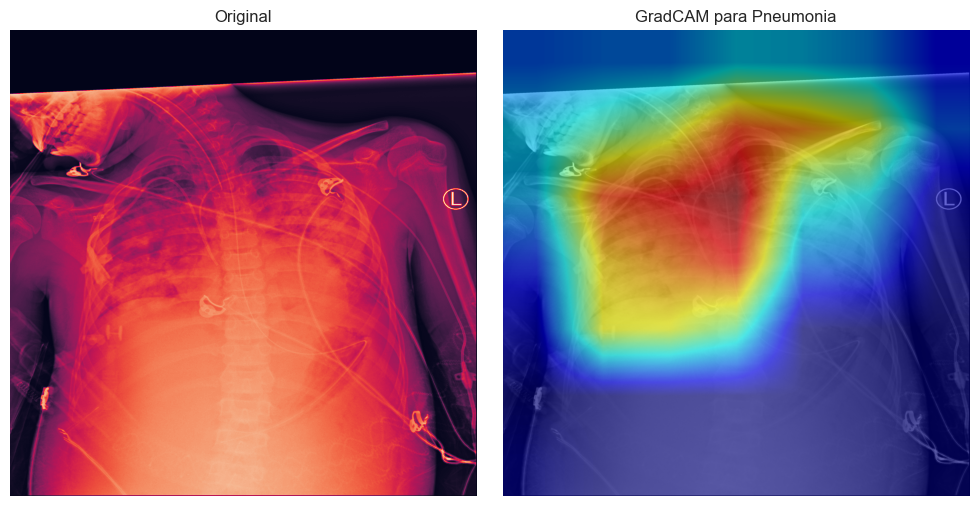


--- Realizando Llamada a API OpenAI ---
Respuesta recibida de OpenAI.

--- Reporte Radiológico Generado por OpenAI API ---
**Reporte Radiológico**

**Paciente ID:** 28873  
**Fecha del Examen:** [Fecha Actual]  
**Tipo de Examen:** Radiografía de Tórax  

**Hallazgos de IA:**  
La IA ha predicho la presencia de neumonía con una probabilidad del 74.61%. El mapa de calor GradCAM muestra activación principalmente en el lóbulo superior derecho del pulmón.

**Interpretación Radiológica Detallada:**

- **Calidad Técnica:**  
  La imagen presenta una penetración adecuada. La inspiración es moderada, pero podría mejorarse. No se observa rotación significativa.

- **Correlación con los Hallazgos Visuales:**  
  En la radiografía original, se observa una opacidad en el lóbulo superior derecho, coincidente con el área de activación del GradCAM, lo cual es sugestivo de consolidación compatible con neumonía. Esta correlación visual apoya la predicción de la IA.

- **Otros Hallazgos:**  
  No se id

In [35]:
# --- Seleccionar una Imagen de Ejemplo y Generar Reporte Real ---
print("\n--- Generando Reporte Radiológico con API Real para una Imagen de Prueba ---")

# Asegurarse que el modelo y los datos de prueba estén listos
if model and test_df_cleaned is not None and not test_df_cleaned.empty and last_conv_layer_name and client:
    # Tomar una imagen aleatoria del conjunto de prueba limpio
    sample_idx_report = random.randint(0, len(test_df_cleaned) - 1)
    report_image_row = test_df_cleaned.iloc[sample_idx_report]
    report_image_path = report_image_row['FullPath']
    report_image_filename = report_image_row[IMAGE_COL]

    print(f"Imagen seleccionada para reporte: {report_image_filename} (Path: {report_image_path})")

    if not os.path.exists(report_image_path):
        print(f"Error: La imagen {report_image_path} no existe.")
    else:
        original_pil_img = Image.open(report_image_path)
        processed_img_array = get_img_array(report_image_path, size=(IMG_HEIGHT, IMG_WIDTH))

        if processed_img_array is not None:
            preds_report = model.predict(processed_img_array, verbose=0)[0]
            pred_idx_report = np.argmax(preds_report)
            pred_label_report = actual_labels[pred_idx_report]
            pred_prob_report = preds_report[pred_idx_report]
            print(f"  Predicción CNN: {pred_label_report} (Prob: {pred_prob_report:.3f})")

            heatmap_report = make_gradcam_heatmap(processed_img_array, model, last_conv_layer_name, pred_index=pred_idx_report)

            if heatmap_report is not None:
                gradcam_pil_img = display_gradcam_pil(original_pil_img, heatmap_report)

                # Visualizar para referencia en el notebook
                plt.figure(figsize=(10, 5)) # Ajustado para dos imágenes
                plt.subplot(1, 2, 1); plt.imshow(original_pil_img); plt.title("Original"); plt.axis('off')
                plt.subplot(1, 2, 2); plt.imshow(gradcam_pil_img); plt.title(f"GradCAM para {pred_label_report}"); plt.axis('off')
                plt.tight_layout()
                plt.show()

                original_b64 = image_to_base64(original_pil_img)
                gradcam_b64 = image_to_base64(gradcam_pil_img)

                system_prompt_llm = "Eres un radiólogo experto con especialización en patologías pulmonares y análisis de radiografías de tórax. Tu tarea es generar un reporte radiológico conciso y profesional basado en la información proporcionada. Sé objetivo y basa tus conclusiones en la evidencia visual y los datos de la IA."

                user_prompt_text_llm = f"""
Por favor, genera un reporte radiológico para el siguiente caso.

**Información del Caso Proporcionada por IA:**
- **Predicción Principal de Patología:** {pred_label_report}
- **Probabilidad Asociada por IA:** {pred_prob_report:.2%}
- **Contexto Visual:** Te proporciono dos imágenes:
    1. La radiografía de tórax original.
    2. Un mapa de calor GradCAM que resalta las regiones que la IA consideró importantes para su predicción de '{pred_label_report}'.

**Instrucciones para el Reporte:**
1.  **Encabezado:** Incluye: Paciente ID (usar "{report_image_row[PATIENT_ID_COL]}" si está disponible, si no "No especificado"), Fecha del Examen (usar fecha actual), Tipo de Examen ("Radiografía de Tórax").
2.  **Hallazgos de IA:** Resume brevemente la predicción de la IA y su probabilidad. Describe dónde se localiza la activación principal del GradCAM.
3.  **Interpretación Radiológica Detallada:**
    * Comenta brevemente la calidad técnica de la imagen original (ej., penetración, inspiración, rotación).
    * Correlaciona la predicción de la IA ({pred_label_report}) con los hallazgos visuales en la radiografía original, prestando especial atención a las áreas resaltadas por el GradCAM.
        * Si la predicción es visualmente consistente, describe los signos radiológicos que la apoyan (ej., "Se observa una opacidad en el lóbulo superior derecho, coincidente con el área de activación del GradCAM, sugestiva de consolidación compatible con {pred_label_report}.").
        * Si la predicción NO es claramente visible o parece incorrecta, justifica tu discrepancia (ej., "A pesar de la predicción de IA de {pred_label_report}, no se identifican signos radiológicos claros de esta patología en la región indicada por GradCAM. Los hallazgos podrían corresponder a superposición de estructuras normales o un artefacto.").
        * Si el GradCAM es difuso o no es útil, indícalo.
    * Describe brevemente otros hallazgos pulmonares, pleurales, mediastínicos o cardíacos relevantes.
4.  **Conclusión/Impresión Diagnóstica:** Ofrece una conclusión concisa. Indica si los hallazgos de la IA son apoyados por tu interpretación visual. Sugiere posibles diagnósticos diferenciales si es apropiado y recomendaciones (ej., "Correlacionar con clínica", "Considerar TC de tórax para mayor caracterización", "Comparar con estudios previos si están disponibles").

**Por favor, genera el reporte.**
"""
                radiology_report_text = call_openai_vision_api(
                    system_prompt=system_prompt_llm,
                    user_prompt_text=user_prompt_text_llm,
                    original_image_b64=original_b64,
                    gradcam_image_b64=gradcam_b64
                )

                print("\n--- Reporte Radiológico Generado por OpenAI API ---")
                for line in radiology_report_text.split('\n'):
                    print(line)
            else:
                print("No se pudo generar el heatmap de GradCAM para la imagen seleccionada.")
        else:
            print("No se pudo preprocesar la imagen seleccionada para el reporte.")
else:
    print("No se puede generar el reporte: El modelo no está cargado, el conjunto de prueba está vacío, no se encontró la última capa convolucional o el cliente de OpenAI no está inicializado.")

